# HACKBATTLE  Impact Through Data - Hackathon Notebook
## Let us explain and show the architecture of our implementation
Thanks for providing us an opportunity to participate in the HackBattle - Impact through data hackathon. We have taken the three datasets provided, cleansed the data and made them as golden data sets. We then leveraged mulitple machine learning algorithms to explore the data, find anomalies and trends and also detect NLP trends like comparing original feedback with re-calculated rating from the text feedback etc.

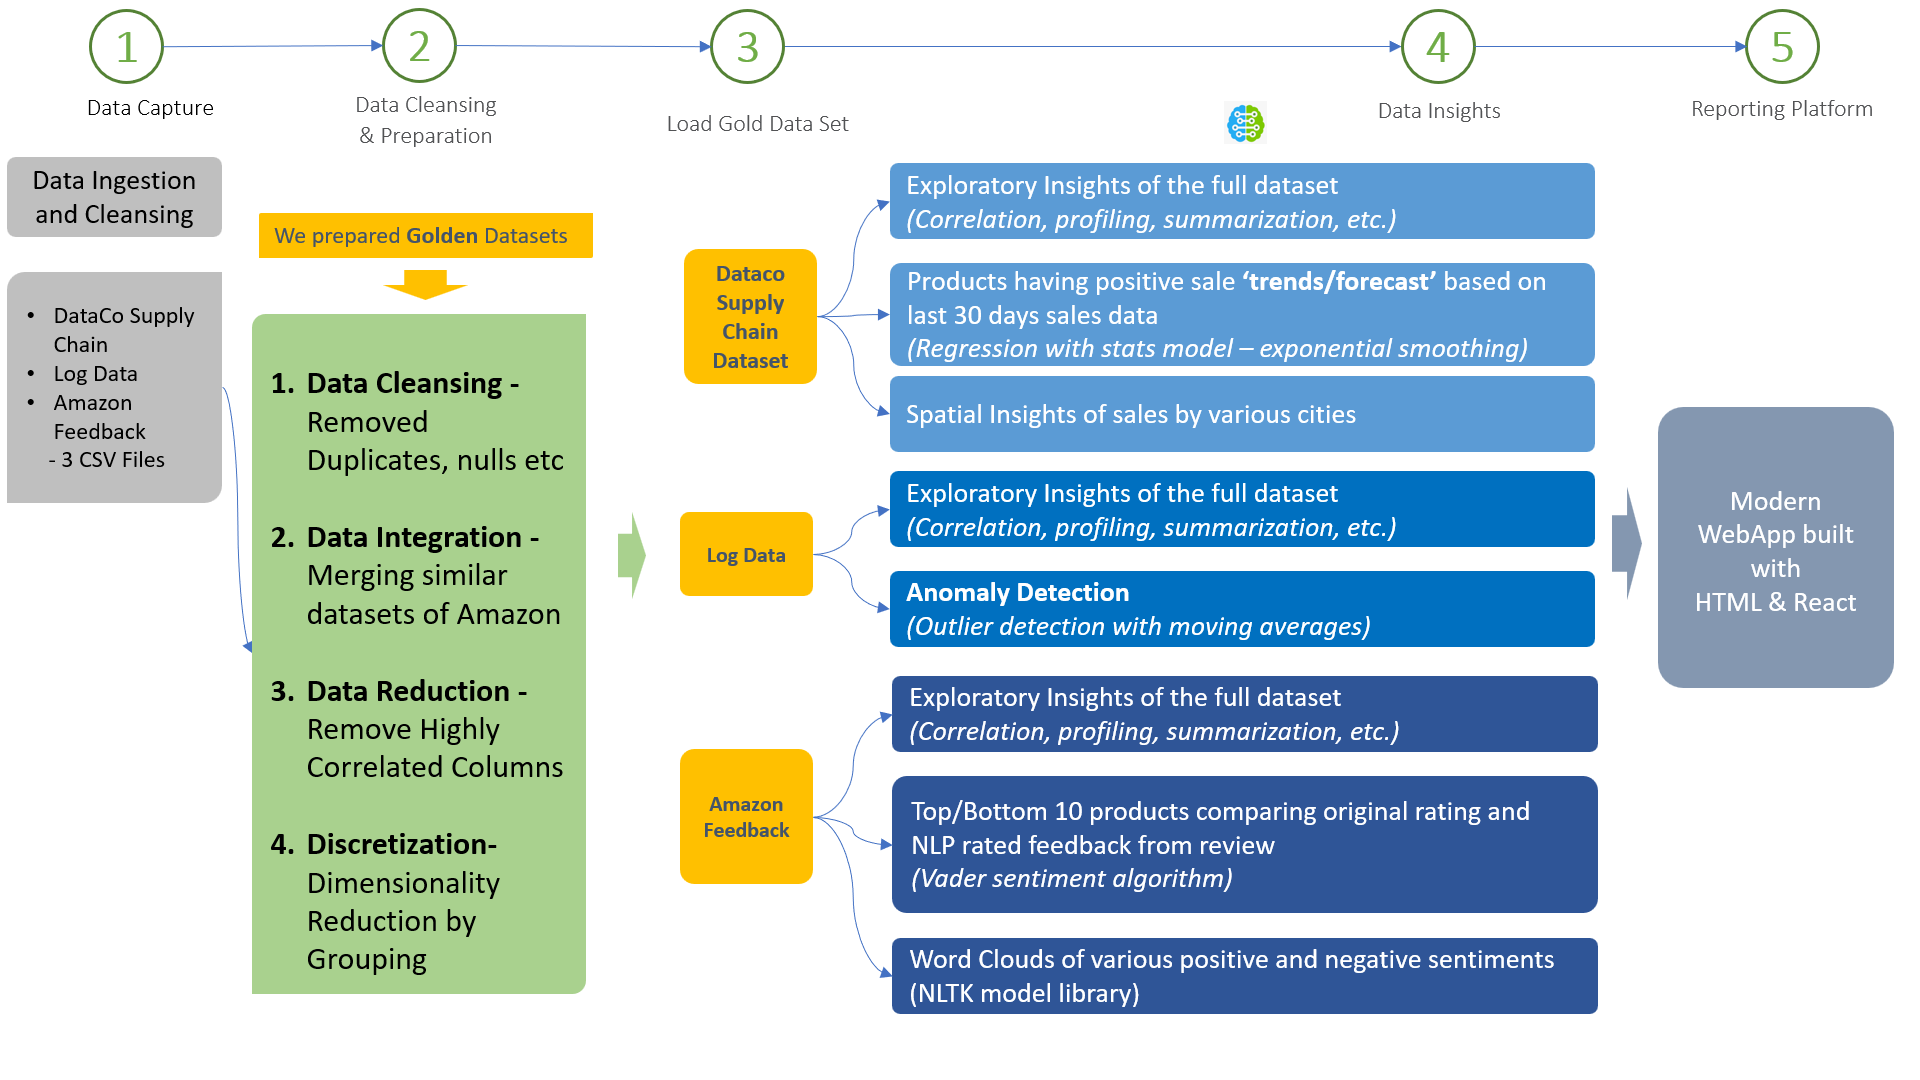

# Setup

## 1.1 Setting up the environment

In [33]:
import string
import collections
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import re
from textwrap import wrap
from textblob import TextBlob
import os
from nltk.corpus import stopwords
from datetime import date, datetime, time
from os import cpu_count
from io import StringIO
import requests
import json
from itertools import groupby
from matplotlib import transforms, pyplot as plt
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud,ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from statsmodels.tsa.api import ExponentialSmoothing
import datetime
import warnings
from IPython.display import HTML
from pandas_profiling import ProfileReport

## 1.2 Initializing the variables

In [2]:
#nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
warnings.filterwarnings("ignore")

# 2. Loading and Preprocessing Of DataSets
## DataCoSupplyChain, Tokenized Access Logs and Amazon Reviews
1. Data Cleansing -   Removed  Duplicates, nulls etc
2. Data Integration - Merging similar datasets of Amazon 
3. Data Reduction -    Remove Highly Correlated Columns
4. Discretization- Dimensionality Reduction by Grouping

### 2.1 Cleansing
1. Trimming white spaces
2. Removing any row which has all columns values as null
3. Drop Duplicates Rows

In [4]:
PATH = '.\\1_HackBattle_Datasets'
i = 2
for file in os.listdir(PATH):           
    if file.endswith(".csv"):
        try:
            df = pd.read_csv(PATH+"\\"+file,low_memory=False)
        except:
            df = pd.read_csv(PATH+"\\"+file, encoding='latin',low_memory=False)
        for column in df:
            if type(df.loc[0,column]) == 'str':
                df[column].str.strip()
        df.dropna(axis=0,how='all', inplace=True)
        df.drop_duplicates(inplace=True)
        if file[0] == '2':
            df.to_csv(".\\2_DataCoSupplyChain_Analytics\\Gold_Dataset\\"+file,index = False,na_rep = 'null')
        if file[0] == '3':
            df.to_csv(".\\3_TokenizedAccessLogs_Analytics\\Gold_Dataset\\"+file,index = False,na_rep = 'null')
        if file[0] == '4':
            df.to_csv(".\\4_AmazonFeedback_Analytics\\Gold_Dataset\\"+file,index = False,na_rep = 'null')

### 2.2 Data Merging
we found an opportunity to merge amazon dataset for improving are analytics. There may be some duplicates that might have crept in while merging the three datasets that needs to be removed.

In [5]:
df_amazon1 = pd.read_csv('.\\4_AmazonFeedback_Analytics\\Gold_Dataset\\4_1429_1.csv')
df_amazon2 = pd.read_csv('.\\4_AmazonFeedback_Analytics\\Gold_Dataset\\4_Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
df_amazon3 = pd.read_csv('.\\4_AmazonFeedback_Analytics\\Gold_Dataset\\4_Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
df_temp1 = pd.concat([df_amazon2, df_amazon3],ignore_index=True,verify_integrity=True)
df_temp2 = pd.concat([df_temp1, df_amazon1],ignore_index=True,verify_integrity=True)
df_temp2.drop_duplicates(inplace=True)
df_temp2.to_csv('.\\4_AmazonFeedback_Analytics\\Gold_Dataset\\AmazonCombined.csv',index = False,na_rep = 'null')

### 2.3 Let us understand the data

In [6]:
# Amazon Dataset
df_amazon = pd.read_csv('.\\4_AmazonFeedback_Analytics\\Gold_Dataset\\AmazonCombined.csv')
df_amazon.describe()

reviews.id  reviews.numHelpful  reviews.rating  reviews.userCity  \
count  7.100000e+01        55151.000000    67864.000000               0.0   
mean   1.837463e+08            0.572320        4.556142               NaN   
std    2.371858e+07           11.596709        0.824936               NaN   
min    1.082112e+08            0.000000        1.000000               NaN   
25%    1.843760e+08            0.000000        4.000000               NaN   
50%    1.880757e+08            0.000000        5.000000               NaN   
75%    1.987126e+08            0.000000        5.000000               NaN   
max    2.085304e+08          814.000000        5.000000               NaN   

       reviews.userProvince  
count                   0.0  
mean                    NaN  
std                     NaN  
min                     NaN  
25%                     NaN  
50%                     NaN  
75%                     NaN  
max                     NaN

In [7]:
# DataCoSupplyChain
df_datacosupplychain = pd.read_csv('.\\2_DataCoSupplyChain_Analytics\\Gold_Dataset\\2_DataCoSupplyChainDataset.csv')
df_datacosupplychain.describe()

Days for shipping (real)  Days for shipment (scheduled)  \
count             180519.000000                  180519.000000   
mean                   3.497654                       2.931847   
std                    1.623722                       1.374449   
min                    0.000000                       0.000000   
25%                    2.000000                       2.000000   
50%                    3.000000                       4.000000   
75%                    5.000000                       4.000000   
max                    6.000000                       4.000000   

       Benefit per order  Sales per customer  Late_delivery_risk  \
count      180519.000000       180519.000000       180519.000000   
mean           21.974989          183.107609            0.548291   
std           104.433526          120.043670            0.497664   
min         -4274.979980            7.490000            0.000000   
25%             7.000000          104.379997            0.000000   
50%            31.520000          163.990005            1.000000   
75%            64.800003          247.399994            1.000000   
max           911.799988         1939.989990            1.000000   

         Category Id    Customer Id  Customer Zipcode  Department Id  \
count  180519.000000  180519.000000     180516.000000  180519.000000   
mean       31.851451    6691.379495      35921.126914       5.443460   
std        15.640064    4162.918106      37542.461122       1.629246   
min         2.000000       1.000000        603.000000       2.000000   
25%        18.000000    3258.500000        725.000000       4.000000   
50%        29.000000    6457.000000      19380.000000       5.000000   
75%        45.000000    9779.000000      78207.000000       7.000000   
max        76.000000   20757.000000      99205.000000      12.000000   

            Latitude  ...  Order Item Quantity          Sales  \
count  180519.000000  ...        180519.000000  180519.000000   
mean       29.719955  ...             2.127638     203.772096   
std         9.813646  ...             1.453451     132.273077   
min       -33.937553  ...             1.000000       9.990000   
25%        18.265432  ...             1.000000     119.980003   
50%        33.144863  ...             1.000000     199.919998   
75%        39.279617  ...             3.000000     299.950012   
max        48.781933  ...             5.000000    1999.989990   

       Order Item Total  Order Profit Per Order  Order Zipcode  \
count     180519.000000           180519.000000   24840.000000   
mean         183.107609               21.974989   55426.132327   
std          120.043670              104.433526   31919.279101   
min            7.490000            -4274.979980    1040.000000   
25%          104.379997                7.000000   23464.000000   
50%          163.990005               31.520000   59405.000000   
75%          247.399994               64.800003   90008.000000   
max         1939.989990              911.799988   99301.000000   

       Product Card Id  Product Category Id  Product Description  \
count    180519.000000        180519.000000                  0.0   
mean        692.509764            31.851451                  NaN   
std         336.446807            15.640064                  NaN   
min          19.000000             2.000000                  NaN   
25%         403.000000            18.000000                  NaN   
50%         627.000000            29.000000                  NaN   
75%        1004.000000            45.000000                  NaN   
max        1363.000000            76.000000                  NaN   

       Product Price  Product Status  
count  180519.000000        180519.0  
mean      141.232550             0.0  
std       139.732492             0.0  
min         9.990000             0.0  
25%        50.000000             0.0  
50%        59.990002             0.0  
75%       199.990005             0.0  
max      1999.989990             0.0  

[8 r

In [10]:
# tokenized logs
df_logs = pd.read_csv('.\\3_TokenizedAccessLogs_Analytics\\Gold_Dataset\\3_tokenized_access_logs.csv')
df_logs.describe()

Hour
count  466728.000000
mean       14.564078
std         5.572751
min         0.000000
25%        10.000000
50%        15.000000
75%        20.000000
max        23.000000

# 3. Load the golden data into memory

In [85]:
df_supplychain = pd.read_csv(".\\2_DataCoSupplyChain_Analytics\\Gold_Dataset\\2_DataCoSupplyChainDataset.csv")
df_logs = pd.read_csv('.\\3_TokenizedAccessLogs_Analytics\\Gold_Dataset\\3_tokenized_access_logs.csv')
df_amazon = pd.read_csv('.\\4_AmazonFeedback_Analytics\\Gold_Dataset\\AmazonCombined.csv')

# 4 Perform Analytics on Golden Datasets

# 4.1 DataCoSupplyChain Insights
### 4.1.1 EDA

In [12]:
df_supplychain = pd.read_csv(".\\2_DataCoSupplyChain_Analytics\\Gold_Dataset\\2_DataCoSupplyChainDataset.csv")
prof = ProfileReport(df_supplychain)
prof.to_file(output_file='.\\2_DataCoSupplyChain_Analytics\\EDA\\EDAOutput.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.2 Spatial Insights and Data Insights
### City Wise Sales and Date wise Customer Sales

In [13]:
df_supplychain = pd.read_csv(".\\2_DataCoSupplyChain_Analytics\\Gold_Dataset\\2_DataCoSupplyChainDataset.csv")
df_geography = df_supplychain.groupby(['Customer City']).sum()['Sales per customer'] 
df_geography2 = df_supplychain.groupby(['Customer City'])
latitude = df_geography2.first()['Latitude']
longitude = df_geography2.first()['Longitude']
# df_geography2 = df_supplychain.groupby(['Customer City']).sum().reset_index()
# df_geography2['Latitude']

In [81]:
# Basemap library
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
 
# Set the dimension of the figure
plt.rcParams["figure.figsize"]=400,390;

m=Basemap(llcrnrlon=-180, llcrnrlat=-65, urcrnrlon=180, urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")  
# prepare a color for each point depending on the continent.
# data['labels_enc'] = pd.factorize(data['homecontinent'])[0]
 
# Add a point per position
m.scatter(
    x=longitude, 
    y=latitude, 
    s=df_geography, 
    alpha=0.4, 
    c=pd.factorize(df_geography.index)[0], 
    cmap="Set1"
)
plt.text( -175, -62,'Total Sales by city', ha='left', va='bottom', size=15, color='#555555' );
# plt.legend(list(df_geography.index))
plt.savefig(".\\2_DataCoSupplyChain_Analytics\\Findings\\Exploratory1.png",dpi=5)
plt.show()

In [27]:
df_supplychain['orderdate(DateOrders)'] = pd.to_datetime(df_supplychain['order date (DateOrders)'])
# Extracting Date from timestamp
for idx in df_supplychain.index:
    df_supplychain.at[idx,'Date'] = str(df_supplychain.loc[idx,'orderdate(DateOrders)'])[:7]

In [28]:
df_month_year = df_supplychain.groupby(['Date']).sum().reset_index()
df_month_year = df_month_year[['Date','Sales per customer','Order Item Discount','Order Item Total']].copy()

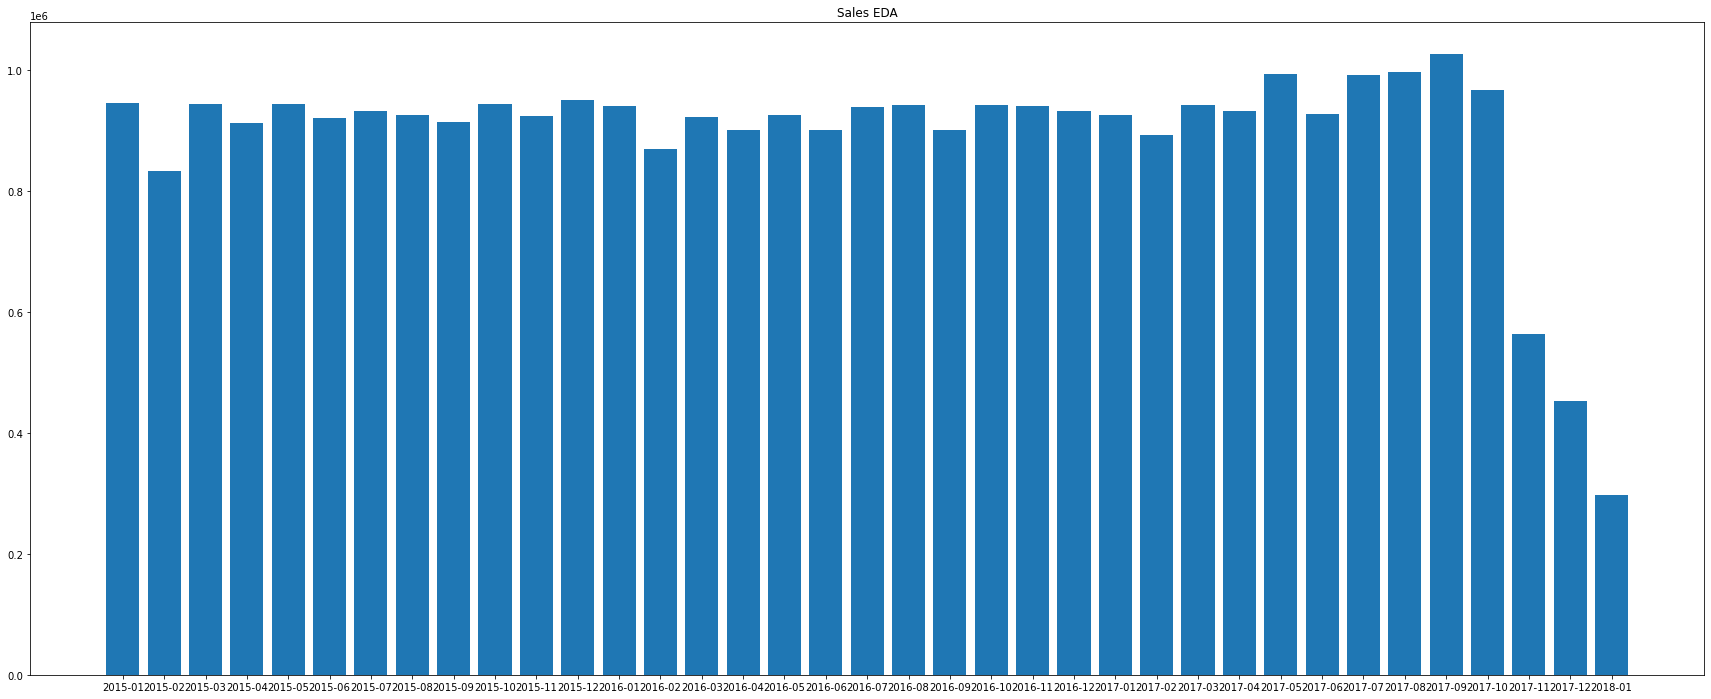

In [82]:
plt.figure(figsize=(30,12))
plt.bar(df_month_year['Date'],df_month_year['Sales per customer'], label = 'Total Sales')
plt.title("Sales EDA")
plt.savefig(".\\2_DataCoSupplyChain_Analytics\\Findings\\Exploratory2.png",bbox_inches="tight",facecolor="1")
plt.show()
# plt.bar(df_month_year['Date'],df_month_year['Order Item Discount'], label = 'Total Discount')
# plt.bar(df_month_year['Date'],df_month_year['Order Item Total'], label = 'Total Order')

### 4.1.3 Analyzing Trends in DataCoSupplyChainDataset

In [49]:
df_trends = pd.read_csv(".\\2_DataCoSupplyChain_Analytics\\Gold_Dataset\\2_DataCoSupplyChainDataset.csv")
df_trends['orderdate(DateOrders)'] = pd.to_datetime(df_trends['order date (DateOrders)'])
# Extracting Date from timestamp
for idx in df_trends.index:
    df_trends.at[idx,'Date'] = str(df_trends.loc[idx,'orderdate(DateOrders)'])[:10]
display(df_trends)

Type  Days for shipping (real)  Days for shipment (scheduled)  \
0          DEBIT                         3                              4   
1       TRANSFER                         5                              4   
2           CASH                         4                              4   
3          DEBIT                         3                              4   
4        PAYMENT                         2                              4   
...          ...                       ...                            ...   
180514      CASH                         4                              4   
180515     DEBIT                         3                              2   
180516  TRANSFER                         5                              4   
180517   PAYMENT                         3                              4   
180518   PAYMENT                         4                              4   

        Benefit per order  Sales per customer   Delivery Status  \
0               91.250000          314.640015  Advance shipping   
1             -249.089996          311.359985     Late delivery   
2             -247.779999          309.720001  Shipping on time   
3               22.860001          304.809998  Advance shipping   
4              134.210007          298.250000  Advance shipping   
...                   ...                 ...               ...   
180514          40.000000          399.980011  Shipping on time   
180515        -613.770019          395.980011     Late delivery   
180516         141.110001          391.980011     Late delivery   
180517         186.229996          387.980011  Advance shipping   
180518         168.949997          383.980011  Shipping on time   

        Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0                        0           73  Sporting Goods        Caguas  ...   
1                        1           73  Sporting Goods        Caguas  ...   
2                        0           73  Sporting Goods      San Jose  ...   
3                        0           73  Sporting Goods   Los Angeles  ...   
4                        0           73  Sporting Goods        Caguas  ...   
...                    ...          ...             ...           ...  ...   
180514                   0           45         Fishing      Brooklyn  ...   
180515                   1           45         Fishing   Bakersfield  ...   
180516                   1           45         Fishing       Bristol  ...   
180517                   0           45         Fishing        Caguas  ...   
180518                   0           45         Fishing        Caguas  ...   

       Product Category Id Product Description  \
0                       73                 NaN   
1                       73                 NaN   
2                       73                 NaN   
3                       73                 NaN   
4                       73                 NaN   
...                    ...                 ...   
180514                  45                 NaN   
180515                  45                 NaN   
180516                  45                 NaN   
180517                  45                 NaN   
180518                  45                 NaN   

                                            Product Image  \
0            http://images.acmesports.sports/Smart+watch    
1            http://images.acmesports.sports/Smart+watch    
2            http://images.acmesports.sports/Smart+watch    
3            http://images.acmesports.sports/Smart+watch    
4            http://images.acmesports.sports/Smart+watch    
...                                                   ...   
180514  http://images.acmesports.sports/Field+%26+Stre...   
180515  http://images.acmesports.sports/Field+%26+Stre...   
180516  http://images.acmesports.sports/Field+%26+Stre...   
180517  http://images.acmesports.sports/Field+%26+Stre...   
180518  http://images.acmesports.sports/Field+%26+Stre...   

           

In [50]:
df_trends = df_trends[['Product Name','Date','Sales']].copy()
df_trends

Product Name        Date       Sales
0                                    Smart watch   2018-01-31  327.750000
1                                    Smart watch   2018-01-13  327.750000
2                                    Smart watch   2018-01-13  327.750000
3                                    Smart watch   2018-01-13  327.750000
4                                    Smart watch   2018-01-13  327.750000
...                                           ...         ...         ...
180514  Field & Stream Sportsman 16 Gun Fire Safe  2016-01-16  399.980011
180515  Field & Stream Sportsman 16 Gun Fire Safe  2016-01-16  399.980011
180516  Field & Stream Sportsman 16 Gun Fire Safe  2016-01-15  399.980011
180517  Field & Stream Sportsman 16 Gun Fire Safe  2016-01-15  399.980011
180518  Field & Stream Sportsman 16 Gun Fire Safe  2016-01-15  399.980011

[180519 rows x 3 columns]

In [51]:
df_trends_group = df_trends.groupby(['Product Name','Date'])
df_trends_group = df_trends_group.sum()
df_trends_group = df_trends_group.reset_index()
df_trends_group

Product Name        Date        Sales
0                    Adult dog supplies  2017-11-29  4979.600090
1                    Adult dog supplies  2017-11-30  5739.200104
2                    Adult dog supplies  2017-12-01  5823.600106
3                    Adult dog supplies  2017-12-02  4220.000076
4                    Adult dog supplies  2018-01-06   844.000015
...                                 ...         ...          ...
22268  insta-bed Neverflat Air Mattress  2017-08-23   449.970016
22269  insta-bed Neverflat Air Mattress  2017-08-26   149.990005
22270  insta-bed Neverflat Air Mattress  2017-08-27   449.970016
22271  insta-bed Neverflat Air Mattress  2017-09-04   149.990005
22272  insta-bed Neverflat Air Mattress  2017-09-09   149.990005

[22273 rows x 3 columns]

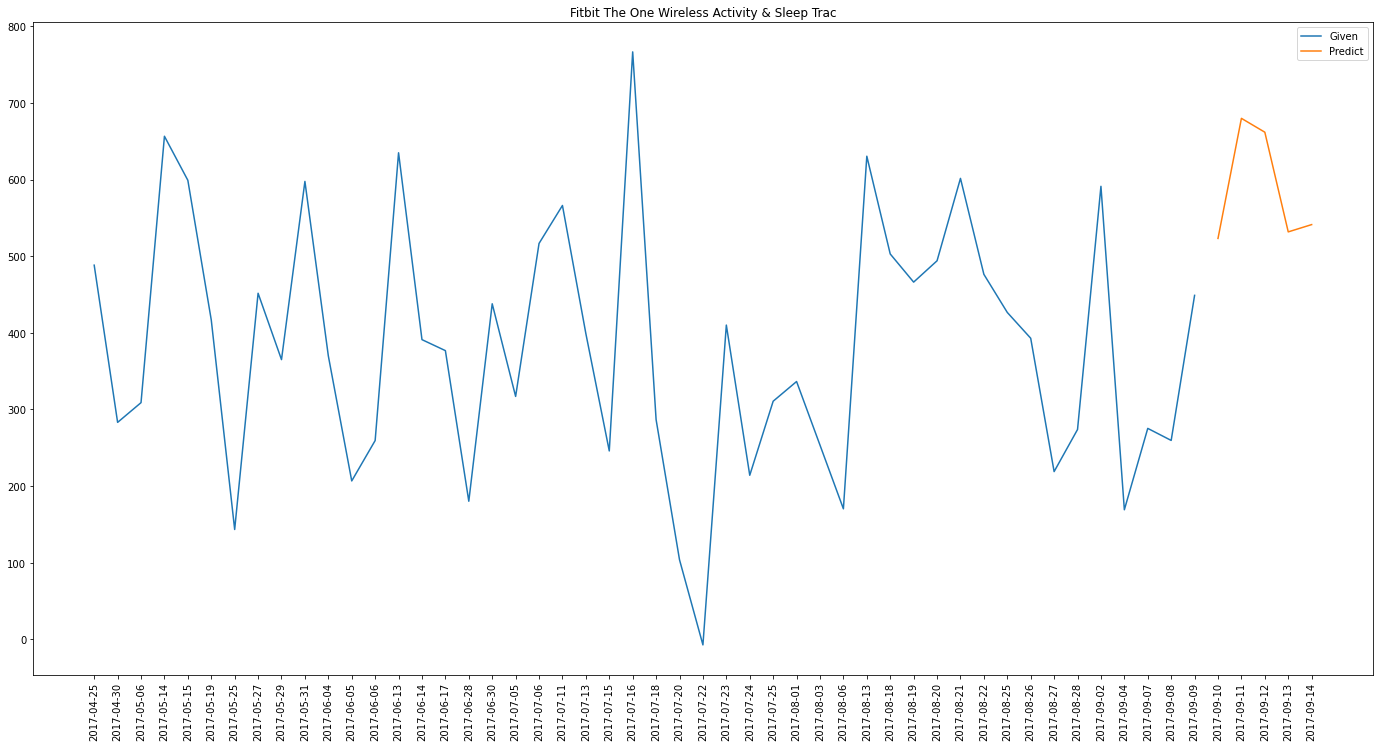

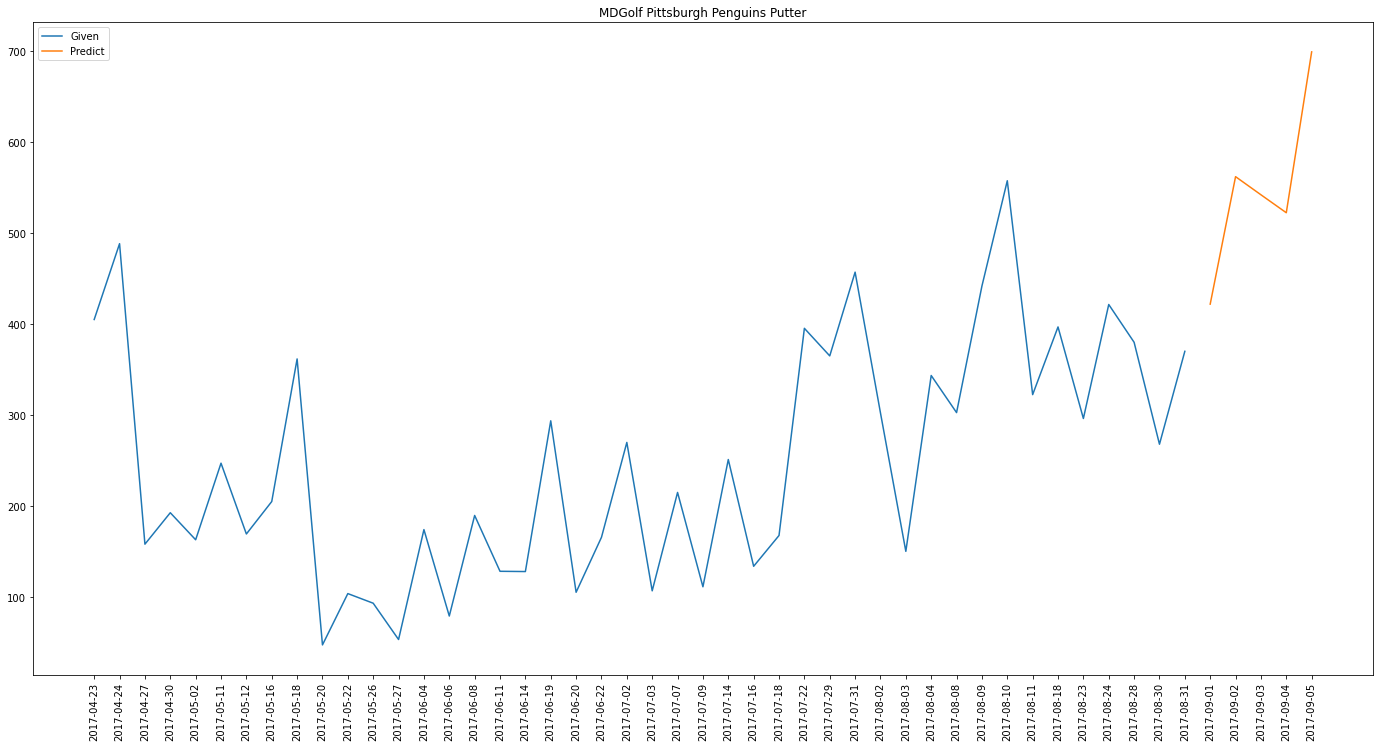

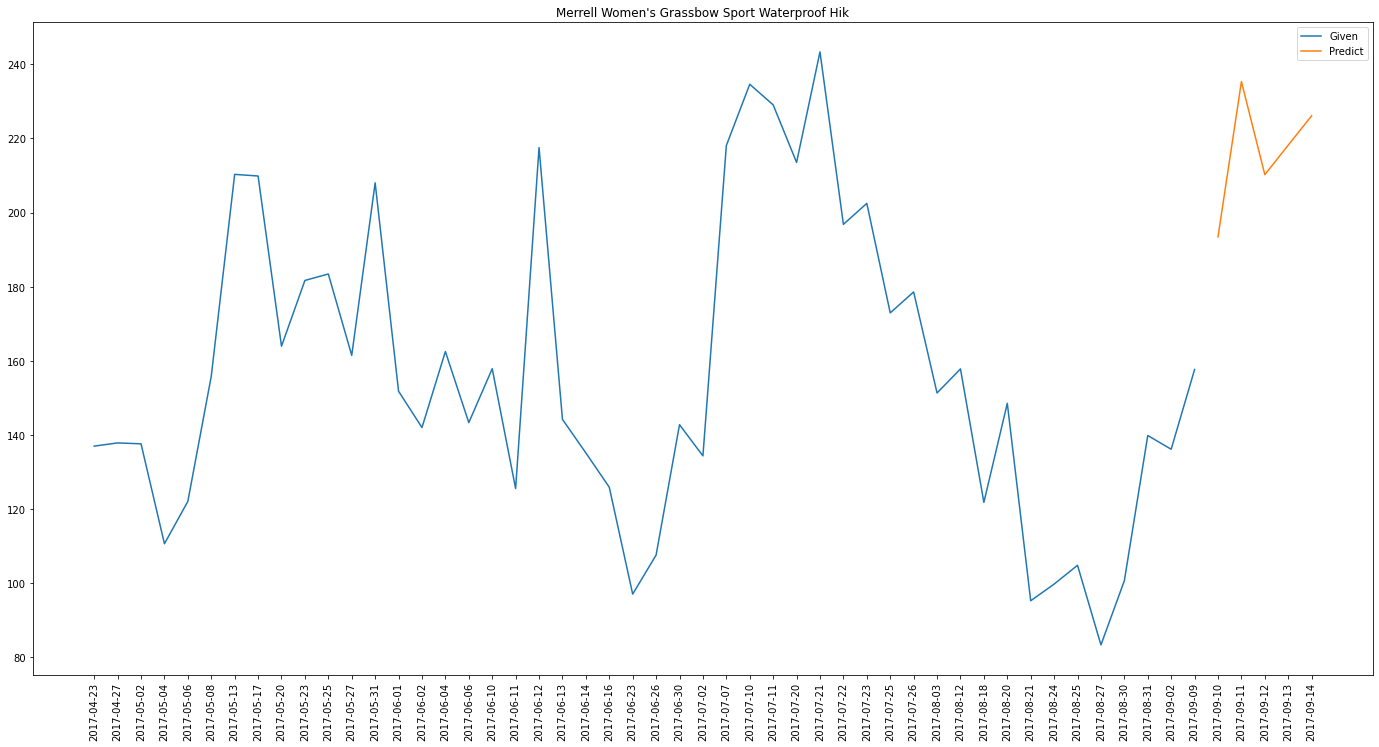

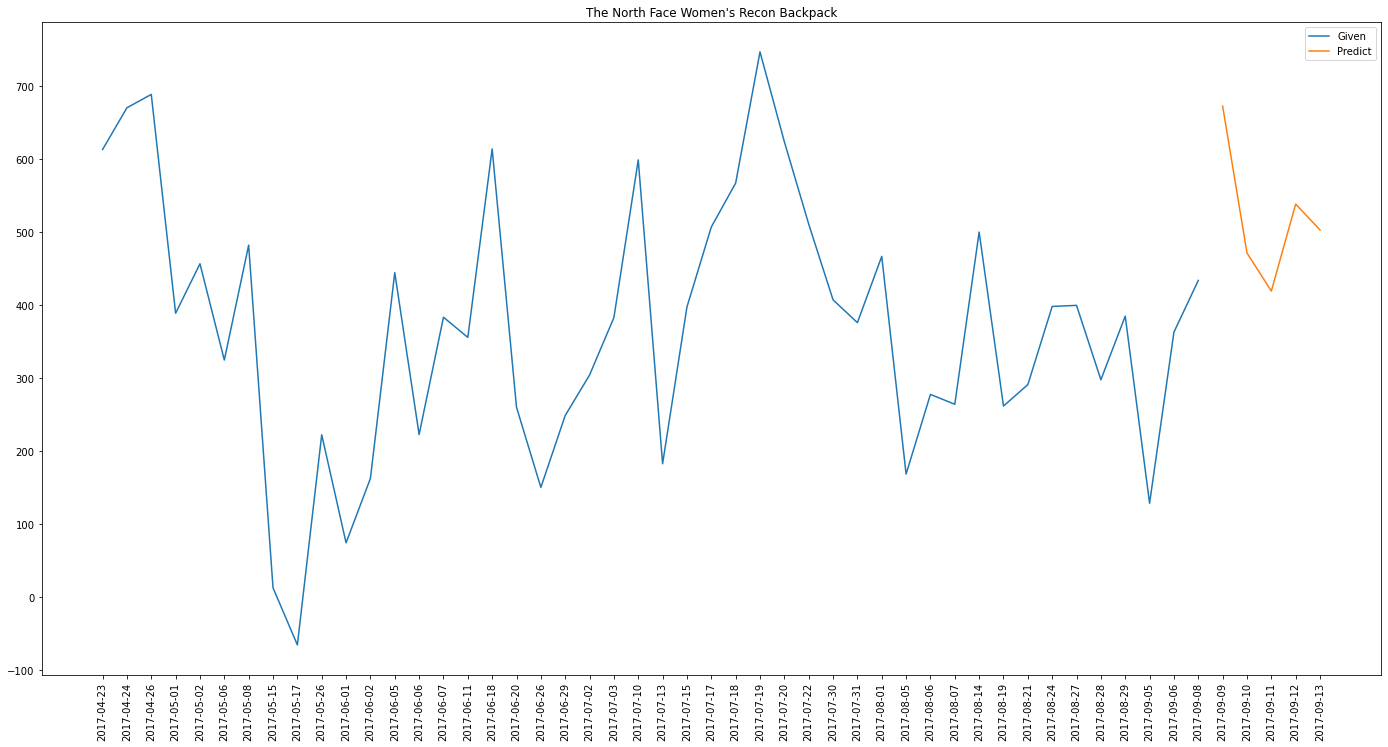

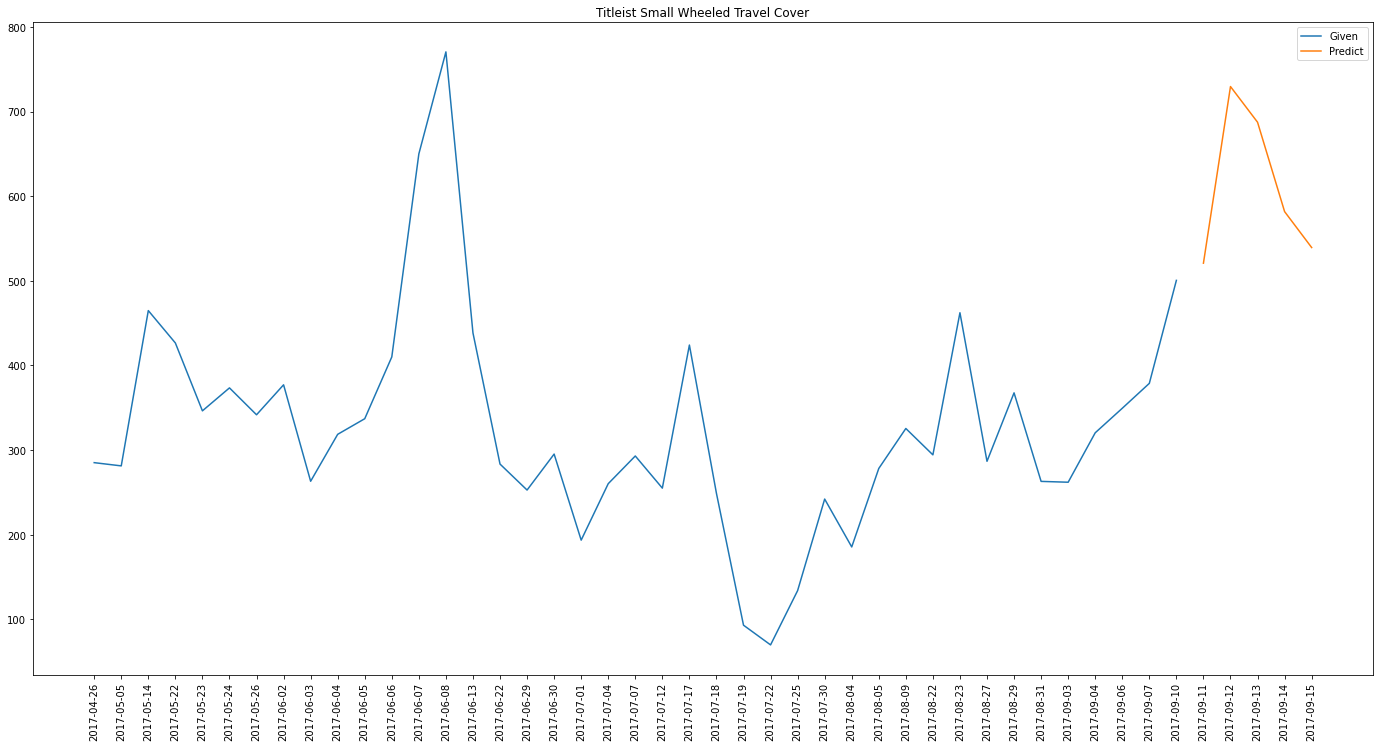

In [84]:
df_products = df_trends_group.groupby(['Product Name'])
product_slope = []
for group,product in df_products:
    #print(product)
    # print(product['Date'].values[len(product['Date'].values)-30:].reshape(-1, 1))
    x= product['Date'].values
    y = product['Sales'].values
#     x=['2020-03-04','2020-03-05','2020-03-06','2020-03-07','2020-03-08']
#     y=[3986,800,3000,4000,354]
    if len(x) < 30 or len(x) >50 :
        continue
    xy = list(zip(x,y))
    #print(xy)
    df_xy = pd.DataFrame(y,index=x,columns=['Sales'])
    #display(df_xy)
    y=df_xy['Sales'].values
    # display(df_xy)
    # break
    # our guessed parameters
    alpha = 0.4
    beta = 0.2
    gamma = 0.01

    # initialise model
    # ets_model = ExponentialSmoothing(y, trend='add', seasonal='add', seasonal_periods=24)
    ets_model = ExponentialSmoothing(df_xy,trend='add', seasonal='add', seasonal_periods=10)
    ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_trend=beta,
    smoothing_seasonal=gamma)

    # forecast p days ahead
    p_ahead = 5
    yh = ets_fit.forecast(p_ahead)
    skipchart = 0
    for i in yh:
        if i<(sum(y)/len(y)):
            skipchart = 1
            continue
    if skipchart == 1:
        continue
#     print(yh)
    #datetime.strptime(date_time_str, '%d/%m/%y %H:%M:%S')
    # plot the y, y_smoothed and y_hat ts'
    #plt.plot(y, label='y')
    plt.figure(figsize=(24,12))
    plt.plot(ets_fit.fittedvalues, label='Given')
    start_date = datetime.datetime.strptime(x[-1], '%Y-%m-%d')+ datetime.timedelta(days=1)
#     start_date = datetime.datetime.strptime(x[-1], '%Y-%m-%d')
    end_date = datetime.datetime.strptime(x[-1], '%Y-%m-%d') + datetime.timedelta(days=p_ahead)
    next_dates = []
    delta = end_date - start_date   # returns timedelta

    for i in range(delta.days+1):
        day = start_date + datetime.timedelta(days=i)
        next_dates.append(day.strftime("%Y-%m-%d"))
    plt.plot(next_dates,yh, label='Predict')
    plt.xticks(rotation=90, size=10)
    plt.legend()
    plt.title(group)
    plt.savefig("2_DataCoSupplyChain_Analytics\Findings\\"+group.replace(' ','')+".png",bbox_inches="tight",facecolor="1")
    plt.show()

## 4.2 Tokenized Access Logs Insights
### 4.2.1 EDA

In [34]:
# import pandas_profiling
# prof_report = pandas_profiling.ProfileReport(df_logs.head(100) , title = 'EDA on Logs Report')
# prof_report.to_widgets()
prof = ProfileReport(df_logs)
prof.to_file(output_file='.\\3_TokenizedAccessLogs_Analytics\\EDA\\EDAOutput.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.2.2 Anomaly Detection

In [36]:
df_anomaly = pd.read_csv('.\\3_TokenizedAccessLogs_Analytics\\Gold_Dataset\\3_tokenized_access_logs.csv')
month_sort_dict={
    'Sep':1,
    'Oct':2,
    'Nov':3,
    'Dec':4,
    'Jan':5
}
df_anomaly['sort_column'] = df_anomaly['Month'].map(month_sort_dict)
df_anomaly.sort_values(by=['sort_column','Hour'], inplace=True)
df_anomaly.reset_index(inplace=True, drop=True)
df_anomaly

Product            Category  \
0       Under Armour Girls' Toddler Spine Surge Runni       shop by sport   
1                  Under Armour Kids' Mercenary Slide         electronics   
2       Yakima DoubleDown Ace Hitch Mount 4-Bike Rack   strength training   
3                    Perfect Fitness Perfect Rip Deck              cleats   
4                        Polar FT4 Heart Rate Monitor    kids' golf clubs   
...                                               ...                 ...   
466723             Under Armour Men's Tech II T-Shirt            lacrosse   
466724      adidas Men's Germany Black Crest Away Tee      girls' apparel   
466725     Merrell Women's Grassbow Sport Hiking Shoe    men's golf clubs   
466726              Nike Men's Free 5.0+ Running Shoe    cardio equipment   
466727               insta-bed Neverflat Air Mattress  hunting & shooting   

                   Date Month  Hour Department              ip  \
0        9/16/2017 0:00   Sep     0      golf     9.198.37.139   
1        9/16/2017 0:00   Sep     0  footwear   173.22.241.228   
2        9/16/2017 0:00   Sep     0  footwear   105.144.62.221   
3        9/16/2017 0:01   Sep     0   apparel     9.198.37.139   
4        9/16/2017 0:01   Sep     0  outdoors   151.30.206.101   
...                 ...   ...   ...        ...             ...   
466723  1/29/2018 23:55   Jan    23   fitness   150.89.112.119   
466724  1/29/2018 23:56   Jan    23      golf    43.228.19.164   
466725  1/29/2018 23:56   Jan    23  outdoors     220.34.42.19   
466726  1/29/2018 23:57   Jan    23  footwear   113.89.175.180   
466727  1/29/2018 23:58   Jan    23  fan shop   88.169.187.201   

                                                      url  sort_column  
0       /department/golf/category/shop%20by%20sport/pr...            1  
1       /department/footwear/category/electronics/prod...            1  
2       /department/footwear/category/strength%20train...            1  
3       /department/apparel/category/cleats/product/Pe...            1  
4       /department/outdoors/category/kids'%20golf%20c...            1  
...                                                   ...          ...  
466723  /department/fitness/category/lacrosse/product/...            5  
466724  /department/golf/category/girls'%20apparel/pro...            5  
466725  /department/outdoors/category/men's%20golf%20c...            5  
466726  /department/footwear/category/cardio%20equipme...            5  
466727  /department/fan%20shop/category/hunting%20&%20...            5  

[466728 rows x 9 columns]

#### Grouping the dataframe based on Month and Hour

In [37]:
df_anomaly_group = df_anomaly.groupby(['Month','Hour'], sort=False)
#df_anomaly_group.first()

#### Finding no of hits in every hour of various months

In [38]:
df_anomaly_group_size=df_anomaly_group.size().reset_index(name="Hits_Counts")
df_anomaly_group_size

Month  Hour  Hits_Counts
0    Sep     0         2226
1    Sep     1         2223
2    Sep     2         2222
3    Sep     3         2214
4    Sep     4         2288
..   ...   ...          ...
93   Jan    19         4783
94   Jan    20         4691
95   Jan    21         4659
96   Jan    22         4492
97   Jan    23         4517

[98 rows x 3 columns]

#### Finding the Anomaly items

In [39]:
def tukey(x, k = 1.5):
    x = np.array(x).copy().astype(float)
    first_quartile = np.quantile(x, .25)
    third_quartile = np.quantile(x, .75)
    
    # Define IQR
    iqr = third_quartile - first_quartile
    
    ### Define the allowed limits for 'Normal Data'
    lower_allowed_limit = first_quartile - (k * iqr)
    upper_allowed_limit = third_quartile + (k * iqr)
    
    #set values below the lower limit/above the upper limit as nan
    x[(x<lower_allowed_limit) | (x>upper_allowed_limit)] = 1
    x[(x>=lower_allowed_limit) & (x<=upper_allowed_limit)] = 0
    return x

In [40]:
hits=df_anomaly_group_size['Hits_Counts'].tolist()
hits_anamoly=tukey(hits)
#print(hits_anamoly)
hits_anamoly=["YES" if x==1.0 else "NO" for x in  hits_anamoly]
#print(hits_anamoly)

In [41]:
df_anomaly_group_size["Anomaly"]=hits_anamoly
df_anomaly_group_size

Month  Hour  Hits_Counts Anomaly
0    Sep     0         2226     YES
1    Sep     1         2223     YES
2    Sep     2         2222     YES
3    Sep     3         2214     YES
4    Sep     4         2288     YES
..   ...   ...          ...     ...
93   Jan    19         4783      NO
94   Jan    20         4691      NO
95   Jan    21         4659      NO
96   Jan    22         4492      NO
97   Jan    23         4517      NO

[98 rows x 4 columns]

#### Preparing X axis for the plot

In [42]:
for idx in df_anomaly_group_size.index:
    df_anomaly_group_size.at[idx,'Hour_Month'] = 'At ' + str(df_anomaly_group_size.loc[idx,'Hour']) + ' Hours in ' + str(df_anomaly_group_size.loc[idx,'Month'])
df_anomaly_group_size

Month  Hour  Hits_Counts Anomaly          Hour_Month
0    Sep     0         2226     YES   At 0 Hours in Sep
1    Sep     1         2223     YES   At 1 Hours in Sep
2    Sep     2         2222     YES   At 2 Hours in Sep
3    Sep     3         2214     YES   At 3 Hours in Sep
4    Sep     4         2288     YES   At 4 Hours in Sep
..   ...   ...          ...     ...                 ...
93   Jan    19         4783      NO  At 19 Hours in Jan
94   Jan    20         4691      NO  At 20 Hours in Jan
95   Jan    21         4659      NO  At 21 Hours in Jan
96   Jan    22         4492      NO  At 22 Hours in Jan
97   Jan    23         4517      NO  At 23 Hours in Jan

[98 rows x 5 columns]

#### Identifying indexes that need to be marked for Anomaly

In [43]:
mark_on =[]
for idx in df_anomaly_group_size.index:
    if df_anomaly_group_size.loc[idx,'Anomaly'] == 'YES':
        mark_on.append(idx)
        

#### Creating a plot for Anomaly Visualization

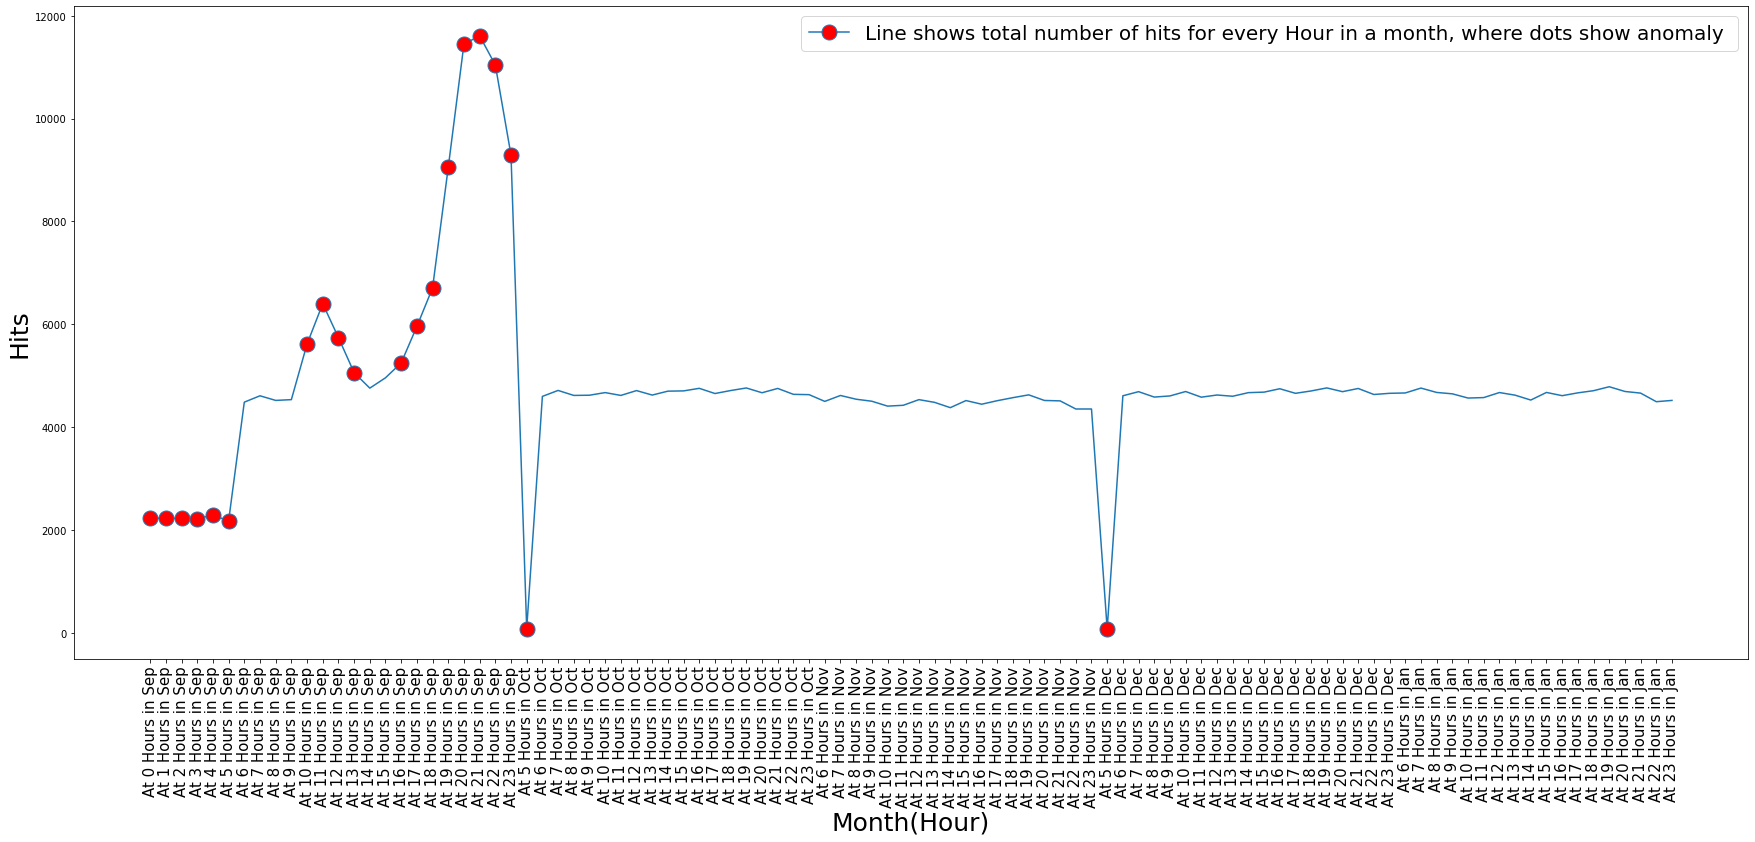

In [48]:
#df_anomaly_group_size.groupby('Month')['Hour']
plt.figure(figsize=(30,12))
plt.plot(df_anomaly_group_size['Hour_Month'], df_anomaly_group_size['Hits_Counts'],markevery=mark_on, marker='o',markersize=15,markerfacecolor='red')
plt.ylabel('Hits', size=25)
plt.xlabel('Month(Hour)', size=25)
plt.xticks(rotation=90, size=15)
plt.legend(("Line shows total number of hits for every Hour in a month, where dots show anomaly ",), fontsize=20)
plt.savefig(".\\3_TokenizedAccessLogs_Analytics\Findings\\Exploratory1.png",bbox_inches="tight",facecolor="1",dpi=50)
plt.show()

## 4.3 Amazon Feedback Analysis
### 4.3.1 EDA

In [35]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df_amazon)
prof.to_file(output_file='.\\4_AmazonFeedback_Analytics\\EDA\\edaAmazon.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.3.2 WorldCloud
We are identifying reviews as positive, negative and neutral.
We are then creating a wordcloud for most used words, most used words in positive, negative and neutral reviews.

In [55]:
df_amazon = pd.read_csv('.\\4_AmazonFeedback_Analytics\\Gold_Dataset\\AmazonCombined.csv')
df_amazon.dropna(axis=0, subset=['name'],inplace=True)
df_amazon

id             dateAdded           dateUpdated  \
0      AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
1      AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
2      AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
3      AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
4      AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
...                     ...                   ...                   ...   
61132  AVpfl8cLLJeJML43AE3S                   NaN                   NaN   
61133  AVpfl8cLLJeJML43AE3S                   NaN                   NaN   
61134  AVpfl8cLLJeJML43AE3S                   NaN                   NaN   
61135  AVpfl8cLLJeJML43AE3S                   NaN                   NaN   
61136  AVpfl8cLLJeJML43AE3S                   NaN                   NaN   

                                                    name  \
0      AmazonBasics AAA Performance Alkaline Batterie...   
1      AmazonBasics AAA Performance Alkaline Batterie...   
2      AmazonBasics AAA Performance Alkaline Batterie...   
3      AmazonBasics AAA Performance Alkaline Batterie...   
4      AmazonBasics AAA Performance Alkaline Batterie...   
...                                                  ...   
61132  New Amazon Kindle Fire Hd 9w Powerfast Adapter...   
61133  New Amazon Kindle Fire Hd 9w Powerfast Adapter...   
61134  New Amazon Kindle Fire Hd 9w Powerfast Adapter...   
61135  New Amazon Kindle Fire Hd 9w Powerfast Adapter...   
61136  New Amazon Kindle Fire Hd 9w Powerfast Adapter...   

                       asins         brand  \
0      B00QWO9P0O,B00LH3DMUO  Amazonbasics   
1      B00QWO9P0O,B00LH3DMUO  Amazonbasics   
2      B00QWO9P0O,B00LH3DMUO  Amazonbasics   
3      B00QWO9P0O,B00LH3DMUO  Amazonbasics   
4      B00QWO9P0O,B00LH3DMUO  Amazonbasics   
...                      ...           ...   
61132  B00L9EPT8O,B01E6AO69U        Amazon   
61133  B00L9EPT8O,B01E6AO69U        Amazon   
61134  B00L9EPT8O,B01E6AO69U        Amazon   
61135  B00L9EPT8O,B01E6AO69U        Amazon   
61136  B00L9EPT8O,B01E6AO69U        Amazon   

                                              categories primaryCategories  \
0      AA,AAA,Health,Electronics,Health & Household,C...   Health & Beauty   
1      AA,AAA,Health,Electronics,Health & Household,C...   Health & Beauty   
2      AA,AAA,Health,Electronics,Health & Household,C...   Health & Beauty   
3      AA,AAA,Health,Electronics,Health & Household,C...   Health & Beauty   
4      AA,AAA,Health,Electronics,Health & Household,C...   Health & Beauty   
...                                                  ...               ...   
61132  Stereos,Remote Controls,Amazon Echo,Audio Dock...               NaN   
61133  Stereos,Remote Controls,Amazon Echo,Audio Dock...               NaN   
61134  Stereos,Remote Controls,Amazon Echo,Audio Dock...               NaN   
61135  Stereos,Remote Controls,Amazon Echo,Audio Dock...               NaN   
61136  Stereos,Remote Controls,Amazon Echo,Audio Dock...               NaN   

                                               imageURLs  \
0      https://images-na.ssl-images-amazon.com/images...   
1      https://images-na.ssl-images-amazon.com/images...   
2      https://images-na.ssl-images-amazon.com/images...   
3      https://images-na.ssl-images-amazon.com/images...   
4      https://images-na.ssl-images-amazon.com/images...   
...                                                  ...   
61132                                                NaN   
61133                                                NaN   
61134                                                NaN   
61135                                                NaN   
61136                                                NaN   

                                                    keys  ...  \
0      amazonbasics/hl002619,amazonbasicsaaaperforman...  ...   
1      amazonbasics/hl002619,amazonbasicsaaaperforman...  ... 

### Extracting useful columns and examining null values in important columns

In [56]:
req_columns = ['name','asins', 'brand', 'primaryCategories','manufacturer', 'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating', 'reviews.title', 'reviews.text','reviews.username']
df_amazon_req_columns = df_amazon[req_columns].copy()
df_amazon_req_columns.isnull().sum()

name                       0
asins                      2
brand                      0
primaryCategories      27900
manufacturer               0
reviews.doRecommend    12737
reviews.numHelpful     12675
reviews.rating            32
reviews.title             16
reviews.text               1
reviews.username           2
dtype: int64

### Dropping duplicate rows and null value rows in name, primary category and reviews title

In [57]:
df_amazon_req_columns.dropna(axis=0, subset=['primaryCategories','reviews.title'],inplace=True)
df_amazon_req_columns

name  \
0      AmazonBasics AAA Performance Alkaline Batterie...   
1      AmazonBasics AAA Performance Alkaline Batterie...   
2      AmazonBasics AAA Performance Alkaline Batterie...   
3      AmazonBasics AAA Performance Alkaline Batterie...   
4      AmazonBasics AAA Performance Alkaline Batterie...   
...                                                  ...   
33232  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33233  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33234  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33235  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33236  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   

                       asins         brand primaryCategories  manufacturer  \
0      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
1      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
2      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
3      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
4      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
...                      ...           ...               ...           ...   
33232             B018Y224PY        Amazon       Electronics        Amazon   
33233             B018Y224PY        Amazon       Electronics        Amazon   
33234             B018Y224PY        Amazon       Electronics        Amazon   
33235             B018Y224PY        Amazon       Electronics        Amazon   
33236             B018Y224PY        Amazon       Electronics        Amazon   

      reviews.doRecommend  reviews.numHelpful  reviews.rating  \
0                     NaN                 NaN             3.0   
1                     NaN                 NaN             4.0   
2                     NaN                 NaN             5.0   
3                     NaN                 NaN             5.0   
4                     NaN                 NaN             5.0   
...                   ...                 ...             ...   
33232                True                 0.0             5.0   
33233                True                 1.0             5.0   
33234                True                 8.0             4.0   
33235                True                 0.0             5.0   
33236                True                 0.0             5.0   

                                           reviews.title  \
0      ... 3 of them and one of the item is bad quali...   
1      ... always the less expensive way to go for pr...   
2      ... are not Duracell but for the price i am ha...   
3      ... as well as name brand batteries at a much ...   
4      ... batteries are very long lasting the price ...   
...                                                  ...   
33232                                       Good product   
33233                                       Great Tablet   
33234                    Great for kids or smaller needs   
33235                       Very sturdy for a 5 year old   
33236                                great little tablet   

                                            reviews.text  reviews.username  
0      I order 3 of them and one of the item is bad q...        Byger yang  
1      Bulk is always the less expensive way to go fo...              ByMG  
2      Well they are not Duracell but for the price i...  BySharon Lambert  
3      Seem to work as well as name brand batteries a...     Bymark sexson  
4      These batteries are very long lasting the pric...           Bylinda  
...                                                  ...               ...  
33232  This is a great tablet for the price. Amazon i...             litle  
33233  This tablet is the perfect size and so easy to...            gracie  
33234  Purchased this for my son. Has room to upgrade...              Hawk  
33235  I had some thoughts about getting this for a 5...           Mrbilly  
33236  this is a steal, have 8 gb model as we

### Converting every character to lower case and removal of stopwords

In [58]:
df_amazon_column_copy = df_amazon_req_columns.copy()
df_amazon_column_copy['reviews.title'] = df_amazon_column_copy['reviews.title'].apply(lambda x: str(x).lower())
df_amazon_column_copy['reviews.text'] = df_amazon_column_copy['reviews.text'].apply(lambda x: str(x).lower())
display(df_amazon_column_copy['reviews.text'])
df_amazon_column_copy['reviews.text'] = df_amazon_column_copy['reviews.text'].apply(lambda x: ' '.join([w for w in x.split(' ') if (w not in STOPWORDS)]))
display(df_amazon_column_copy['reviews.text'])

0        i order 3 of them and one of the item is bad q...
1        bulk is always the less expensive way to go fo...
2        well they are not duracell but for the price i...
3        seem to work as well as name brand batteries a...
4        these batteries are very long lasting the pric...
                               ...                        
33232    this is a great tablet for the price. amazon i...
33233    this tablet is the perfect size and so easy to...
33234    purchased this for my son. has room to upgrade...
33235    i had some thoughts about getting this for a 5...
33236    this is a steal, have 8 gb model as well.this ...
Name: reviews.text, Length: 33224, dtype: object

0        order 3 one item bad quality. missing backup s...
1          bulk always less expensive way go products like
2                               well duracell price happy.
3        seem work well name brand batteries much bette...
4                      batteries long lasting price great.
                               ...                        
33232                  great tablet price. amazon good job
33233    tablet perfect size easy use. read, play games...
33234    purchased son. room upgrade memory allow books...
33235    thoughts getting 5 year old, get screen protec...
33236                  steal, 8 gb model well.this punch..
Name: reviews.text, Length: 33224, dtype: object

###  Making the corpus of words

In [59]:
corpus=[]
corpus = [w for s in df_amazon_column_copy['reviews.text'].str.split().values.tolist() for w in s]
counter = collections.Counter(corpus)
most_common_words = counter.most_common()
most_common_words

[('great', 9536),
 ('good', 5696),
 ('batteries', 5671),
 ('tablet', 5621),
 ('love', 4508),
 ('use', 4008),
 ('amazon', 3976),
 ('bought', 3872),
 ('easy', 3598),
 ('it.', 3151),
 ('price', 3085),
 ('one', 2954),
 ('like', 2920),
 ('kindle', 2909),
 ('loves', 2689),
 ('would', 2490),
 ('long', 2301),
 ('kids', 2266),
 ('last', 2256),
 ('fire', 2178),
 ('buy', 2172),
 ('get', 2149),
 ('work', 2136),
 ('old', 2107),
 ('battery', 1961),
 ('year', 1907),
 ('works', 1805),
 ('well', 1800),
 ('much', 1782),
 ('really', 1729),
 ('price.', 1594),
 ('time', 1593),
 ('tablet.', 1574),
 ('product', 1572),
 ('best', 1566),
 ('purchased', 1556),
 ('screen', 1556),
 ('batteries.', 1548),
 ('got', 1531),
 ('apps', 1528),
 ('better', 1437),
 ('also', 1432),
 ('play', 1358),
 ('games', 1354),
 ('nice', 1274),
 ('read', 1253),
 ('used', 1206),
 ('new', 1185),
 ('little', 1184),
 ('perfect', 1174),
 ('recommend', 1165),
 ('quality', 1149),
 ("i'm", 1136),
 ('reading', 1123),
 ('use.', 1114),
 ('name', 1

###  Distributing the reviews in positive, negative and neutral sets

In [60]:
sentiment_score={1:0,
                2:0,
                3:0.5,
                4:1,
                5:1}
sentiment={0:'Negative',
          1:'Positive',
          0.5:'Neutral'}
df_amazon_column_copy['sentiment_score']=df_amazon_column_copy['reviews.rating'].map(sentiment_score)
df_amazon_column_copy['sentiment']=df_amazon_column_copy['sentiment_score'].map(sentiment)

df_amazon_column_copy.head(5)

name                  asins  \
0  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
1  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
2  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
3  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
4  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   

          brand primaryCategories  manufacturer reviews.doRecommend  \
0  Amazonbasics   Health & Beauty  AmazonBasics                 NaN   
1  Amazonbasics   Health & Beauty  AmazonBasics                 NaN   
2  Amazonbasics   Health & Beauty  AmazonBasics                 NaN   
3  Amazonbasics   Health & Beauty  AmazonBasics                 NaN   
4  Amazonbasics   Health & Beauty  AmazonBasics                 NaN   

   reviews.numHelpful  reviews.rating  \
0                 NaN             3.0   
1                 NaN             4.0   
2                 NaN             5.0   
3                 NaN             5.0   
4                 NaN             5.0   

                                       reviews.title  \
0  ... 3 of them and one of the item is bad quali...   
1  ... always the less expensive way to go for pr...   
2  ... are not duracell but for the price i am ha...   
3  ... as well as name brand batteries at a much ...   
4  ... batteries are very long lasting the price ...   

                                        reviews.text  reviews.username  \
0  order 3 one item bad quality. missing backup s...        Byger yang   
1    bulk always less expensive way go products like              ByMG   
2                         well duracell price happy.  BySharon Lambert   
3  seem work well name brand batteries much bette...     Bymark sexson   
4                batteries long lasting price great.           Bylinda   

   sentiment_score sentiment  
0              0.5   Neutral  
1              1.0  Positive  
2              1.0  Positive  
3              1.0  Positive  
4              1.0  Positive

###  Creating a chart displaying percentage of various reviews

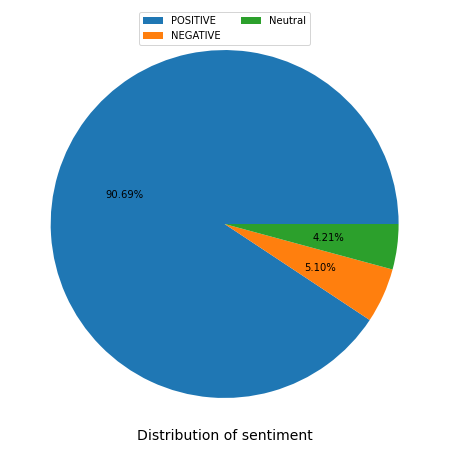

In [61]:
plt.figure(figsize = (8, 8))

labels = ['POSITIVE', 'NEGATIVE', 'Neutral']
plt.pie(df_amazon_column_copy['sentiment'].value_counts(), autopct='%0.2f%%')

plt.title('Distribution of sentiment', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.savefig("4_AmazonFeedback_Analytics\Findings\\ReviewsPie.png",bbox_inches="tight",facecolor="1")
plt.show()

### Creating a combined word cloud

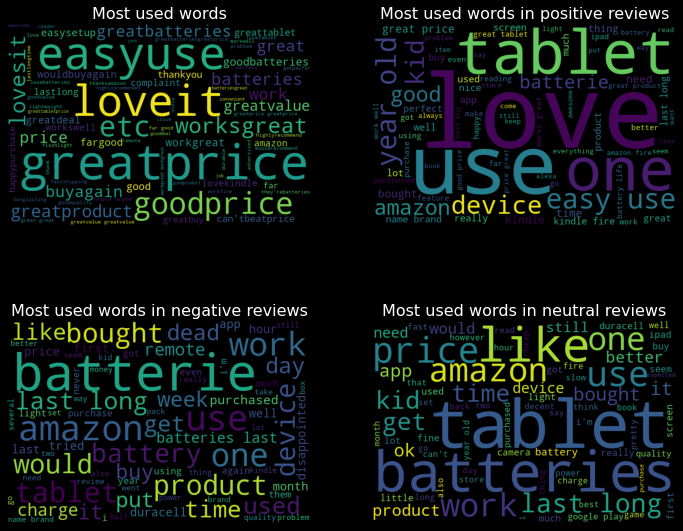

In [63]:
plt.rcParams["figure.figsize"] =[12, 10]
fig, axs = plt.subplots(2, 2)
# fig1 = plt.figure("Figure 1")
wordcloud1=WordCloud(width=600,height=400,max_words=75).generate(''.join(corpus))
axs[0,0].imshow(wordcloud1)
axs[0,0].set_title('Most used words',size =16, color='white' )
axs[0,0].axis('off')
# plt.show()

#fig2 = plt.figure("Figure 2")
positive_words=pd.Series(''.join(df_amazon_column_copy[df_amazon_column_copy['sentiment']=='Positive'] ['reviews.text']).split())
wordcloud2 = WordCloud(width=600,height=400,max_words=75).generate(' '.join(positive_words))
axs[0,1].imshow(wordcloud2)
axs[0,1].set_title("Most used words in positive reviews", size=16, color='white')
axs[0,1].axis("off")
# plt.show()

#fig3 = plt.figure("Figure 3")
negative_words = pd.Series(' '.join(df_amazon_column_copy[df_amazon_column_copy['sentiment']=='Negative']['reviews.text']).split())
wordcloud3 = WordCloud(stopwords=['good','great'],width=600,height=400,max_words=75).generate(' '.join(negative_words))
axs[1,0].imshow(wordcloud3)
axs[1,0].set_title("Most used words in negative reviews", size=16, color='white')
axs[1,0].axis("off")
# plt.show()

#fig4 = plt.figure("Figure 4")
neutral_words = pd.Series(' '.join(df_amazon_column_copy[df_amazon_column_copy['sentiment']=='Neutral']['reviews.text']).split())
wordcloud4= WordCloud(stopwords=['good','great'],width=600,height=400,max_words=75).generate(' '.join(neutral_words))
axs[1,1].imshow(wordcloud4)
axs[1,1].set_title("Most used words in neutral reviews", size=16, color='white')
axs[1,1].axis("off")
fig.patch.set_facecolor('black')
plt.savefig("4_AmazonFeedback_Analytics\Findings\\wordcloud.png")
plt.show()

## 4.3.3 Compare original rating with re-calculated rating from the user provided text

In [64]:
df_amazon = pd.read_csv('.\\4_AmazonFeedback_Analytics\\Gold_Dataset\\AmazonCombined.csv')
df_amazon.dropna(axis=0, subset=['name', 'reviews.rating', 'reviews.text', 'reviews.date','primaryCategories'],inplace=True)
df_amazon

id             dateAdded           dateUpdated  \
0      AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
1      AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
2      AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
3      AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
4      AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
...                     ...                   ...                   ...   
33232  AVqkIdZiv8e3D1O-leaJ  2017-03-06T14:59:25Z  2017-09-04T11:19:31Z   
33233  AVqkIdZiv8e3D1O-leaJ  2017-03-06T14:59:25Z  2017-09-04T11:19:31Z   
33234  AVqkIdZiv8e3D1O-leaJ  2017-03-06T14:59:25Z  2017-09-04T11:19:31Z   
33235  AVqkIdZiv8e3D1O-leaJ  2017-03-06T14:59:25Z  2017-09-04T11:19:31Z   
33236  AVqkIdZiv8e3D1O-leaJ  2017-03-06T14:59:25Z  2017-09-04T11:19:31Z   

                                                    name  \
0      AmazonBasics AAA Performance Alkaline Batterie...   
1      AmazonBasics AAA Performance Alkaline Batterie...   
2      AmazonBasics AAA Performance Alkaline Batterie...   
3      AmazonBasics AAA Performance Alkaline Batterie...   
4      AmazonBasics AAA Performance Alkaline Batterie...   
...                                                  ...   
33232  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33233  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33234  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33235  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33236  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   

                       asins         brand  \
0      B00QWO9P0O,B00LH3DMUO  Amazonbasics   
1      B00QWO9P0O,B00LH3DMUO  Amazonbasics   
2      B00QWO9P0O,B00LH3DMUO  Amazonbasics   
3      B00QWO9P0O,B00LH3DMUO  Amazonbasics   
4      B00QWO9P0O,B00LH3DMUO  Amazonbasics   
...                      ...           ...   
33232             B018Y224PY        Amazon   
33233             B018Y224PY        Amazon   
33234             B018Y224PY        Amazon   
33235             B018Y224PY        Amazon   
33236             B018Y224PY        Amazon   

                                              categories primaryCategories  \
0      AA,AAA,Health,Electronics,Health & Household,C...   Health & Beauty   
1      AA,AAA,Health,Electronics,Health & Household,C...   Health & Beauty   
2      AA,AAA,Health,Electronics,Health & Household,C...   Health & Beauty   
3      AA,AAA,Health,Electronics,Health & Household,C...   Health & Beauty   
4      AA,AAA,Health,Electronics,Health & Household,C...   Health & Beauty   
...                                                  ...               ...   
33232  Tablets,Fire Tablets,Electronics,iPad & Tablet...       Electronics   
33233  Tablets,Fire Tablets,Electronics,iPad & Tablet...       Electronics   
33234  Tablets,Fire Tablets,Electronics,iPad & Tablet...       Electronics   
33235  Tablets,Fire Tablets,Electronics,iPad & Tablet...       Electronics   
33236  Tablets,Fire Tablets,Electronics,iPad & Tablet...       Electronics   

                                               imageURLs  \
0      https://images-na.ssl-images-amazon.com/images...   
1      https://images-na.ssl-images-amazon.com/images...   
2      https://images-na.ssl-images-amazon.com/images...   
3      https://images-na.ssl-images-amazon.com/images...   
4      https://images-na.ssl-images-amazon.com/images...   
...                                                  ...   
33232  https://images-na.ssl-images-amazon.com/images...   
33233  https://images-na.ssl-images-amazon.com/images...   
33234  https://images-na.ssl-images-amazon.com/images...   
33235  https://images-na.ssl-images-amazon.com/images...   
33236  https://images-na.ssl-images-amazon.com/images...   

                                                    keys  ...  \
0      amazonbasics/hl002619,amazonbasicsaaaperforman...  ...   
1      amazonbasics/hl002619,amazonbasicsaaaperforman...  ... 

### Extracting Important columns

In [65]:
req_columns = ['name', 'asins', 'brand','primaryCategories', 'manufacturer',
       'reviews.date', 'reviews.doRecommend','reviews.numHelpful', 'reviews.rating',
       'reviews.text', 'reviews.title', 'reviews.username',]
df_amazon = df_amazon[req_columns].copy()
df_amazon

name  \
0      AmazonBasics AAA Performance Alkaline Batterie...   
1      AmazonBasics AAA Performance Alkaline Batterie...   
2      AmazonBasics AAA Performance Alkaline Batterie...   
3      AmazonBasics AAA Performance Alkaline Batterie...   
4      AmazonBasics AAA Performance Alkaline Batterie...   
...                                                  ...   
33232  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33233  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33234  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33235  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33236  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   

                       asins         brand primaryCategories  manufacturer  \
0      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
1      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
2      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
3      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
4      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
...                      ...           ...               ...           ...   
33232             B018Y224PY        Amazon       Electronics        Amazon   
33233             B018Y224PY        Amazon       Electronics        Amazon   
33234             B018Y224PY        Amazon       Electronics        Amazon   
33235             B018Y224PY        Amazon       Electronics        Amazon   
33236             B018Y224PY        Amazon       Electronics        Amazon   

                   reviews.date reviews.doRecommend  reviews.numHelpful  \
0      2017-03-02T00:00:00.000Z                 NaN                 NaN   
1      2016-08-31T00:00:00.000Z                 NaN                 NaN   
2      2016-12-06T00:00:00.000Z                 NaN                 NaN   
3      2016-03-28T00:00:00.000Z                 NaN                 NaN   
4      2017-04-22T00:00:00.000Z                 NaN                 NaN   
...                         ...                 ...                 ...   
33232  2016-10-21T00:00:00.000Z                True                 0.0   
33233  2016-08-10T00:00:00.000Z                True                 1.0   
33234  2016-06-05T00:00:00.000Z                True                 8.0   
33235  2016-09-02T00:00:00.000Z                True                 0.0   
33236  2016-05-19T00:00:00.000Z                True                 0.0   

       reviews.rating                                       reviews.text  \
0                 3.0  I order 3 of them and one of the item is bad q...   
1                 4.0  Bulk is always the less expensive way to go fo...   
2                 5.0  Well they are not Duracell but for the price i...   
3                 5.0  Seem to work as well as name brand batteries a...   
4                 5.0  These batteries are very long lasting the pric...   
...               ...                                                ...   
33232             5.0  This is a great tablet for the price. Amazon i...   
33233             5.0  This tablet is the perfect size and so easy to...   
33234             4.0  Purchased this for my son. Has room to upgrade...   
33235             5.0  I had some thoughts about getting this for a 5...   
33236             5.0  this is a steal, have 8 gb model as well.This ...   

                                           reviews.title  reviews.username  
0      ... 3 of them and one of the item is bad quali...        Byger yang  
1      ... always the less expensive way to go for pr...              ByMG  
2      ... are not Duracell but for the price i am ha...  BySharon Lambert  
3      ... as well as name brand batteries at a much ...     Bymark sexson  
4      ... batteries are very long lasting the price ...           Bylinda  
...                                                  ...               ...  
33232                                    

### For every row extracting date from Timestamp

In [66]:
for idx in df_amazon.index:
    df_amazon.at[idx,'date'] = df_amazon.loc[idx,'reviews.date'][:10]
df_amazon

name  \
0      AmazonBasics AAA Performance Alkaline Batterie...   
1      AmazonBasics AAA Performance Alkaline Batterie...   
2      AmazonBasics AAA Performance Alkaline Batterie...   
3      AmazonBasics AAA Performance Alkaline Batterie...   
4      AmazonBasics AAA Performance Alkaline Batterie...   
...                                                  ...   
33232  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33233  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33234  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33235  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33236  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   

                       asins         brand primaryCategories  manufacturer  \
0      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
1      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
2      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
3      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
4      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
...                      ...           ...               ...           ...   
33232             B018Y224PY        Amazon       Electronics        Amazon   
33233             B018Y224PY        Amazon       Electronics        Amazon   
33234             B018Y224PY        Amazon       Electronics        Amazon   
33235             B018Y224PY        Amazon       Electronics        Amazon   
33236             B018Y224PY        Amazon       Electronics        Amazon   

                   reviews.date reviews.doRecommend  reviews.numHelpful  \
0      2017-03-02T00:00:00.000Z                 NaN                 NaN   
1      2016-08-31T00:00:00.000Z                 NaN                 NaN   
2      2016-12-06T00:00:00.000Z                 NaN                 NaN   
3      2016-03-28T00:00:00.000Z                 NaN                 NaN   
4      2017-04-22T00:00:00.000Z                 NaN                 NaN   
...                         ...                 ...                 ...   
33232  2016-10-21T00:00:00.000Z                True                 0.0   
33233  2016-08-10T00:00:00.000Z                True                 1.0   
33234  2016-06-05T00:00:00.000Z                True                 8.0   
33235  2016-09-02T00:00:00.000Z                True                 0.0   
33236  2016-05-19T00:00:00.000Z                True                 0.0   

       reviews.rating                                       reviews.text  \
0                 3.0  I order 3 of them and one of the item is bad q...   
1                 4.0  Bulk is always the less expensive way to go fo...   
2                 5.0  Well they are not Duracell but for the price i...   
3                 5.0  Seem to work as well as name brand batteries a...   
4                 5.0  These batteries are very long lasting the pric...   
...               ...                                                ...   
33232             5.0  This is a great tablet for the price. Amazon i...   
33233             5.0  This tablet is the perfect size and so easy to...   
33234             4.0  Purchased this for my son. Has room to upgrade...   
33235             5.0  I had some thoughts about getting this for a 5...   
33236             5.0  this is a steal, have 8 gb model as well.This ...   

                                           reviews.title  reviews.username  \
0      ... 3 of them and one of the item is bad quali...        Byger yang   
1      ... always the less expensive way to go for pr...              ByMG   
2      ... are not Duracell but for the price i am ha...  BySharon Lambert   
3      ... as well as name brand batteries at a much ...     Bymark sexson   
4      ... batteries are very long lasting the price ...           Bylinda   
...                                                  ...               ...   
33232                             

In [67]:
# Since reviews_date is now no more required We are removing it
df_amazon.drop(['reviews.date'],axis=1, inplace=True)

### Finding the sentiment of text for each review

In [68]:
analyzer = SentimentIntensityAnalyzer()
for idx in df_amazon.index:
    sentence = df_amazon.loc[idx,'reviews.text']
    value = analyzer.polarity_scores(sentence)['compound']
    # Converting Rating from -1 to 1 into 1 to 5
    newValue = ((((value) - (-1)) * (5 - 1)) / (1 - (-1))) + 1
    df_amazon.at[idx,'textSentimentRating'] = newValue
df_amazon

name  \
0      AmazonBasics AAA Performance Alkaline Batterie...   
1      AmazonBasics AAA Performance Alkaline Batterie...   
2      AmazonBasics AAA Performance Alkaline Batterie...   
3      AmazonBasics AAA Performance Alkaline Batterie...   
4      AmazonBasics AAA Performance Alkaline Batterie...   
...                                                  ...   
33232  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33233  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33234  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33235  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33236  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   

                       asins         brand primaryCategories  manufacturer  \
0      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
1      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
2      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
3      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
4      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
...                      ...           ...               ...           ...   
33232             B018Y224PY        Amazon       Electronics        Amazon   
33233             B018Y224PY        Amazon       Electronics        Amazon   
33234             B018Y224PY        Amazon       Electronics        Amazon   
33235             B018Y224PY        Amazon       Electronics        Amazon   
33236             B018Y224PY        Amazon       Electronics        Amazon   

      reviews.doRecommend  reviews.numHelpful  reviews.rating  \
0                     NaN                 NaN             3.0   
1                     NaN                 NaN             4.0   
2                     NaN                 NaN             5.0   
3                     NaN                 NaN             5.0   
4                     NaN                 NaN             5.0   
...                   ...                 ...             ...   
33232                True                 0.0             5.0   
33233                True                 1.0             5.0   
33234                True                 8.0             4.0   
33235                True                 0.0             5.0   
33236                True                 0.0             5.0   

                                            reviews.text  \
0      I order 3 of them and one of the item is bad q...   
1      Bulk is always the less expensive way to go fo...   
2      Well they are not Duracell but for the price i...   
3      Seem to work as well as name brand batteries a...   
4      These batteries are very long lasting the pric...   
...                                                  ...   
33232  This is a great tablet for the price. Amazon i...   
33233  This tablet is the perfect size and so easy to...   
33234  Purchased this for my son. Has room to upgrade...   
33235  I had some thoughts about getting this for a 5...   
33236  this is a steal, have 8 gb model as well.This ...   

                                           reviews.title  reviews.username  \
0      ... 3 of them and one of the item is bad quali...        Byger yang   
1      ... always the less expensive way to go for pr...              ByMG   
2      ... are not Duracell but for the price i am ha...  BySharon Lambert   
3      ... as well as name brand batteries at a much ...     Bymark sexson   
4      ... batteries are very long lasting the price ...           Bylinda   
...                                                  ...               ...   
33232                                       Good product             litle   
33233                                       Great Tablet            gracie   
33234                    Great for kids or smaller needs              Hawk   
33235                       Very sturdy for a 5 year old           Mrbilly   
33236                             

### Finding the aveage rating between stars rating given and text sentiment rating

In [69]:
for idx in df_amazon.index:
    df_amazon.at[idx,'averageRating'] = (df_amazon.loc[idx,'reviews.rating'] + df_amazon.loc[idx,'textSentimentRating'])/2
display(df_amazon)


name  \
0      AmazonBasics AAA Performance Alkaline Batterie...   
1      AmazonBasics AAA Performance Alkaline Batterie...   
2      AmazonBasics AAA Performance Alkaline Batterie...   
3      AmazonBasics AAA Performance Alkaline Batterie...   
4      AmazonBasics AAA Performance Alkaline Batterie...   
...                                                  ...   
33232  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33233  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33234  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33235  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   
33236  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...   

                       asins         brand primaryCategories  manufacturer  \
0      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
1      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
2      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
3      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
4      B00QWO9P0O,B00LH3DMUO  Amazonbasics   Health & Beauty  AmazonBasics   
...                      ...           ...               ...           ...   
33232             B018Y224PY        Amazon       Electronics        Amazon   
33233             B018Y224PY        Amazon       Electronics        Amazon   
33234             B018Y224PY        Amazon       Electronics        Amazon   
33235             B018Y224PY        Amazon       Electronics        Amazon   
33236             B018Y224PY        Amazon       Electronics        Amazon   

      reviews.doRecommend  reviews.numHelpful  reviews.rating  \
0                     NaN                 NaN             3.0   
1                     NaN                 NaN             4.0   
2                     NaN                 NaN             5.0   
3                     NaN                 NaN             5.0   
4                     NaN                 NaN             5.0   
...                   ...                 ...             ...   
33232                True                 0.0             5.0   
33233                True                 1.0             5.0   
33234                True                 8.0             4.0   
33235                True                 0.0             5.0   
33236                True                 0.0             5.0   

                                            reviews.text  \
0      I order 3 of them and one of the item is bad q...   
1      Bulk is always the less expensive way to go fo...   
2      Well they are not Duracell but for the price i...   
3      Seem to work as well as name brand batteries a...   
4      These batteries are very long lasting the pric...   
...                                                  ...   
33232  This is a great tablet for the price. Amazon i...   
33233  This tablet is the perfect size and so easy to...   
33234  Purchased this for my son. Has room to upgrade...   
33235  I had some thoughts about getting this for a 5...   
33236  this is a steal, have 8 gb model as well.This ...   

                                           reviews.title  reviews.username  \
0      ... 3 of them and one of the item is bad quali...        Byger yang   
1      ... always the less expensive way to go for pr...              ByMG   
2      ... are not Duracell but for the price i am ha...  BySharon Lambert   
3      ... as well as name brand batteries at a much ...     Bymark sexson   
4      ... batteries are very long lasting the price ...           Bylinda   
...                                                  ...               ...   
33232                                       Good product             litle   
33233                                       Great Tablet            gracie   
33234                    Great for kids or smaller needs              Hawk   
33235                       Very sturdy for a 5 year old           Mrbilly   
33236                             

### Grouping of products by name and finding average for every product

In [70]:
df_group1 = df_amazon.groupby(['name'])
df_temp = df_group1[['reviews.rating', 'textSentimentRating','averageRating']].mean()
df_temp.reset_index(inplace=True)
df_temp

name  reviews.rating  \
0   All-New Fire 7 Tablet with Alexa, 7" Display, ...        4.585366   
1   All-New Fire HD 8 Kids Edition Tablet, 8 HD Di...        4.630901   
2   All-New Fire HD 8 Kids Edition Tablet, 8 HD Di...        4.641638   
3   All-New Fire HD 8 Tablet with Alexa, 8 HD Disp...        4.578709   
4   All-New Fire HD 8 Tablet with Alexa, 8 HD Disp...        4.600000   
..                                                ...             ...   
74  Kindle PowerFast International Charging Kit (f...        4.800000   
75  Kindle Voyage E-reader, 6 High-Resolution Disp...        4.888889   
76  Kindle Voyage E-reader, 6 High-Resolution Disp...        4.726733   
77  Oem Amazon Kindle Power Usb Adapter Wall Trave...        1.000000   
78  Two Door Top Load Pet Kennel Travel Crate Dog ...        5.000000   

    textSentimentRating  averageRating  
0              4.261976       4.423671  
1              4.367201       4.499051  
2              4.323796       4.482717  
3              4.260873       4.419791  
4              4.176082       4.388041  
..                  ...            ...  
74             4.645120       4.722560  
75             4.339322       4.614106  
76             4.427639       4.577186  
77             2.331550       1.665775  
78             4.837200       4.918600  

[79 rows x 4 columns]

### Sorting of ratings

In [71]:
df_text_rating = df_temp.sort_values(by='textSentimentRating',ascending=False)
df_text_rating.reset_index(drop=True, inplace=True)
df_text_rating

name  reviews.rating  \
0                AmazonBasics 11.6-Inch Laptop Sleeve        4.000000   
1   Two Door Top Load Pet Kennel Travel Crate Dog ...        5.000000   
2   All-new Echo (2nd Generation) with improved so...        5.000000   
3                          Echo Spot Pair Kit (Black)        4.500000   
4   Amazon Echo (1st Generationcertified) Color:Wh...        4.307692   
..                                                ...             ...   
74                     Echo Dot (Previous generation)        4.000000   
75  Amazon Kindle Replacement Power Adapter (Fits ...        2.800000   
76  AmazonBasics Silicone Hot Handle Cover/Holder ...        4.000000   
77  Certified Refurbished Amazon Fire TV with Alex...        2.800000   
78  Oem Amazon Kindle Power Usb Adapter Wall Trave...        1.000000   

    textSentimentRating  averageRating  
0              4.945700       4.472850  
1              4.837200       4.918600  
2              4.819900       4.909950  
3              4.743100       4.621550  
4              4.725985       4.516838  
..                  ...            ...  
74             3.497200       3.748600  
75             3.474280       3.137140  
76             3.000000       3.500000  
77             2.480240       2.640120  
78             2.331550       1.665775  

[79 rows x 4 columns]

###  creating dataframe for top 10 and bottom 10 products

In [72]:
df_top = df_text_rating.head(10)
df_top

name  reviews.rating  \
0               AmazonBasics 11.6-Inch Laptop Sleeve        4.000000   
1  Two Door Top Load Pet Kennel Travel Crate Dog ...        5.000000   
2  All-new Echo (2nd Generation) with improved so...        5.000000   
3                         Echo Spot Pair Kit (Black)        4.500000   
4  Amazon Echo (1st Generationcertified) Color:Wh...        4.307692   
5  AmazonBasics Nespresso Pod Storage Drawer - 50...        5.000000   
6  All-New Kindle Oasis E-reader - 7 High-Resolut...        4.428571   
7  Cat Litter Box Covered Tray Kitten Extra Large...        5.000000   
8  Kindle PowerFast International Charging Kit (f...        4.800000   
9  Amazon Fire TV Gaming Edition Streaming Media ...        4.666667   

   textSentimentRating  averageRating  
0             4.945700       4.472850  
1             4.837200       4.918600  
2             4.819900       4.909950  
3             4.743100       4.621550  
4             4.725985       4.516838  
5             4.704200       4.852100  
6             4.693543       4.561057  
7             4.661900       4.830950  
8             4.645120       4.722560  
9             4.626000       4.646333

In [73]:
df_bot = df_text_rating.tail(10).sort_values(by='textSentimentRating',ascending=True).reset_index(drop=True)
df_bot

name  reviews.rating  \
0  Oem Amazon Kindle Power Usb Adapter Wall Trave...        1.000000   
1  Certified Refurbished Amazon Fire TV with Alex...        2.800000   
2  AmazonBasics Silicone Hot Handle Cover/Holder ...        4.000000   
3  Amazon Kindle Replacement Power Adapter (Fits ...        2.800000   
4                     Echo Dot (Previous generation)        4.000000   
5                              Amazon Echo ‚Äì White        5.000000   
6      AmazonBasics 16-Gauge Speaker Wire - 100 Feet        5.000000   
7  Amazon 9W PowerFast Official OEM USB Charger a...        4.737705   
8  Amazon Fire TV with 4K Ultra HD and Alexa Voic...        5.000000   
9  AmazonBasics AAA Performance Alkaline Batterie...        4.448040   

   textSentimentRating  averageRating  
0             2.331550       1.665775  
1             2.480240       2.640120  
2             3.000000       3.500000  
3             3.474280       3.137140  
4             3.497200       3.748600  
5             3.585900       4.292950  
6             3.729080       4.364540  
7             3.796007       4.266856  
8             3.821050       4.410525  
9             3.870320       4.159180

###  Plotting top 10 products by reviews

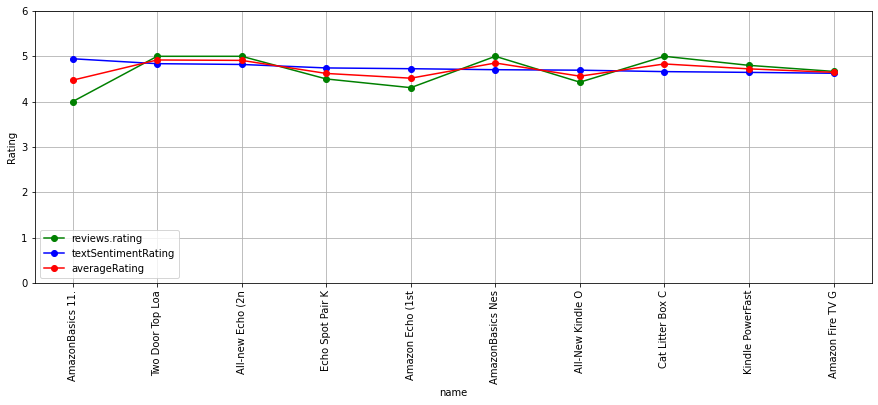

In [77]:
fig=plt.figure(figsize=(15,5))
for idx in df_top.index:
    df_top.at[idx,'short.name'] = df_top.loc[idx,'name'][:16]
plt.plot(df_top['short.name'],df_top['reviews.rating'],color="green",marker='o')
plt.plot(df_top['short.name'],df_top['textSentimentRating'],color="blue",marker='o')
plt.plot(df_top['short.name'],df_top['averageRating'],color="red",marker='o')
plt.xlabel('name')
plt.ylabel('Rating')
plt.grid(True)
plt.xticks(fontstretch='ultra-condensed',rotation=90)
plt.ylim([0,6])
plt.legend(('reviews.rating','textSentimentRating','averageRating'))
plt.savefig("4_AmazonFeedback_Analytics\Findings\\top10.png",bbox_inches="tight",facecolor="1")

### Plotting bottom 10 products by review

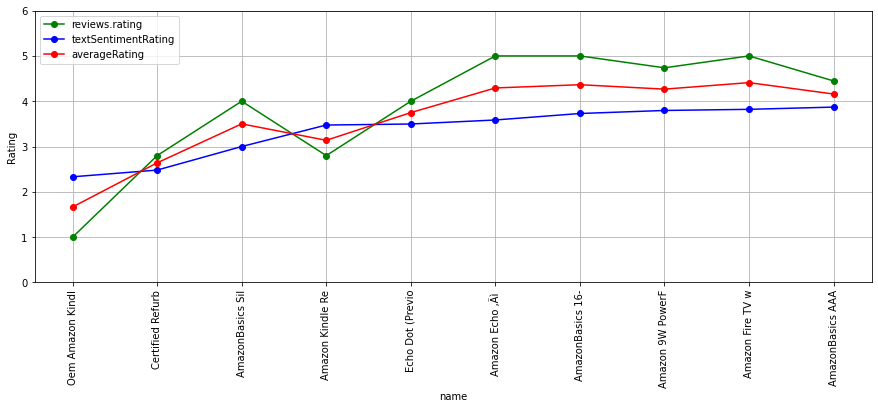

In [76]:
fig=plt.figure(figsize=(15,5))
for idx in df_bot.index:
    df_bot.at[idx,'short_name'] = df_bot.loc[idx,'name'][:16]
plt.plot(df_bot['short_name'],df_bot['reviews.rating'],color="green",marker='o')
plt.plot(df_bot['short_name'],df_bot['textSentimentRating'],color="blue",marker='o')
plt.plot(df_bot['short_name'],df_bot['averageRating'],color="red",marker='o')
plt.xlabel('name')
plt.ylabel('Rating')
plt.grid(True)
plt.xticks(fontstretch='ultra-condensed',rotation=90)
plt.ylim([0,6])
plt.legend(('reviews.rating','textSentimentRating','averageRating'))
plt.savefig("4_AmazonFeedback_Analytics\Findings\\bottom10.png",bbox_inches="tight",facecolor="1")

# Thank You